In [ ]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#파이토치 설치_세그멘테이션
!pip install -U segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
#필요 라이브러리 불러오기
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [ ]:
#데이터 클래스 정의
class ClearGraspDataset(Dataset):
    def __init__(self, image_dir, edge_dir, transform=None):
        self.image_dir = image_dir
        self.edge_dir = edge_dir
        self.transform = transform

        image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
        edge_files  = [f for f in os.listdir(edge_dir) if f.endswith('.jpg') or f.endswith('.png')]

        #오류 방지 위해 공백 제거한 이름을 기준으로 매칭
        image_map = {f.replace(" ", "").rsplit(".", 1)[0]: f for f in image_files}
        edge_map  = {f.replace(" ", "").rsplit(".", 1)[0]: f for f in edge_files}

        common_keys = sorted(set(image_map.keys()) & set(edge_map.keys()))

        if not common_keys:
            raise ValueError("일치하는 이미지-마스크 쌍이 없습니다.")

        self.image_files = [image_map[k] for k in common_keys]
        self.edge_files  = [edge_map[k] for k in common_keys]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        edge_path = os.path.join(self.edge_dir, self.edge_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        edge = cv2.imread(edge_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, edge=edge)
            image = augmented["image"]
            edge = augmented["edge"]  # 이미 Tensor

        return image, edge.long()

In [ ]:
#데이터 셋 및 데이터 로더 구성하기

#학습셋 경로
train_image_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/train/images"
train_edge_dir  = "/content/drive/MyDrive/Cleargrasp_Dataset/train/outlines/outline"

#검증셋 경로
val_image_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/val/image/images"
val_edge_dir  = "/content/drive/MyDrive/Cleargrasp_Dataset/val/outlines/outline"

import albumentations as A
from albumentations.pytorch import ToTensorV2

#데이터 변환
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'edge': 'mask'})

#Dataset 정의
train_dataset = ClearGraspDataset(train_image_dir, train_edge_dir, transform=transform)
val_dataset   = ClearGraspDataset(val_image_dir, val_edge_dir, transform=transform)

#DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

'''
#Dataset 정의
train_dataset = ClearGraspDataset(train_image_dir, train_edge_dir, transform=transform)
val_dataset   = ClearGraspDataset(val_image_dir, val_edge_dir, transform=transform)

#DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
'''

'\n#Dataset 정의\ntrain_dataset = ClearGraspDataset(train_image_dir, train_edge_dir, transform=transform)\nval_dataset   = ClearGraspDataset(val_image_dir, val_edge_dir, transform=transform)\n\n#DataLoader 정의\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)\nval_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)\n'

In [ ]:
#데이터 개수 확인
print(f"Train셋 크기: {len(train_dataset)}개")
print(f"Val셋 크기  : {len(val_dataset)}개")

sample_img, sample_edge = train_dataset[0]
print("이미지 shape:", sample_img.shape)
print("edge shape:", sample_edge.shape)

Train셋 크기: 45454개
Val셋 크기  : 532개
이미지 shape: torch.Size([3, 256, 256])
edge shape: torch.Size([256, 256])


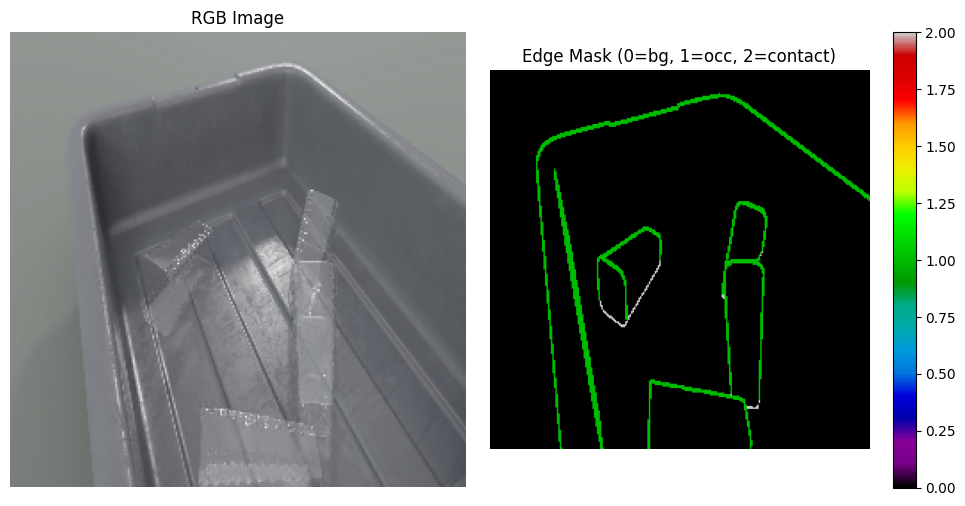

In [ ]:
#이미지와 엣지가 잘 매핑됐나 확인
import matplotlib.pyplot as plt

#정규화 해제 함수_없으면 사진이 파랗게 나옴
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

#첫 샘플 가져오기
image_tensor, mask_tensor = train_dataset[0]

#정규화 해제
image_tensor = denormalize(image_tensor)

#Tensor → NumPy로 변환_오류 없애기 위함
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()   # (C, H, W) → (H, W, C)
image_np = np.clip(image_np, 0, 1).astype(np.float32)

mask_np = mask_tensor.cpu().numpy()

#시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='nipy_spectral', vmin=0, vmax=2)
plt.title("Edge Mask (0=bg, 1=occ, 2=contact)")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#사전학습된 U-net 모델 로딩
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
).cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
#손실함수 및 최적화함수
class_weights = torch.tensor([1.0, 4.0, 6.0]).cuda() #가중치 추가
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
'''
기존 학습루프
#학습 루프
def train_model(n_epochs=10):
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for imgs, edges in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            imgs, edges = imgs.cuda(), edges.cuda()
            outputs = model(imgs)
            loss = criterion(outputs, edges)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, edges in val_loader:
                imgs, edges = imgs.cuda(), edges.cuda()
                outputs = model(imgs)
                loss = criterion(outputs, edges)
                val_loss += loss.item()

        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_cleargrasp_unet.pth")
            print("Best model saved")
            '''

In [ ]:
#earlystopping 추가한 학습루프
def train_model(n_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0  # 개선되지 않은 epoch 수
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for imgs, edges in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            imgs, edges = imgs.cuda(), edges.cuda()
            outputs = model(imgs)
            loss = criterion(outputs, edges)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, edges in val_loader:
                imgs, edges = imgs.cuda(), edges.cuda()
                outputs = model(imgs)
                loss = criterion(outputs, edges)
                val_loss += loss.item()

        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

        # 개선 여부 확인
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(model.state_dict(), "best_cleargrasp_unet.pth")
            print("✅ Best model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

        # patience 초과 시 학습 종료
        if epochs_no_improve >= patience:
            print(f"⛔ Early stopping triggered after {patience} epochs without improvement.")
            break

In [ ]:
#정규화 해제 함수 정의
def visualize_predictions():
    model.eval()
    imgs, edges = next(iter(val_loader))
    imgs, edges = imgs.cuda(), edges.cuda()

    with torch.no_grad():
        preds = model(imgs)
        preds = torch.argmax(preds, dim=1)

    #정규화 해제 + torch에서 clamp + numpy로 변환
    imgs = denormalize(imgs)
    imgs = imgs.clamp(0, 1).cpu()
    imgs = imgs.permute(0, 2, 3, 1).numpy()
    imgs = np.clip(imgs, 0, 1).astype(np.float32)  # float32로 고정

    edges = edges.cpu().numpy()
    preds = preds.cpu().numpy()

    for i in range(min(3, len(imgs))):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(imgs[i])
        axs[0].set_title("RGB Image")

        axs[1].imshow(edges[i], cmap='nipy_spectral', vmin=0, vmax=2)
        axs[1].set_title("Ground Truth")

        axs[2].imshow(preds[i], cmap='nipy_spectral', vmin=0, vmax=2)
        axs[2].set_title("Prediction")

        for ax in axs:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

Epoch 1/50: 100%|██████████| 1421/1421 [6:50:23<00:00, 17.33s/it]


Epoch 1 | Train Loss: 0.1900 | Val Loss: 0.1288
✅ Best model saved.


Epoch 2/50: 100%|██████████| 1421/1421 [12:42<00:00,  1.86it/s]


Epoch 2 | Train Loss: 0.1025 | Val Loss: 0.1107
✅ Best model saved.


Epoch 3/50: 100%|██████████| 1421/1421 [12:31<00:00,  1.89it/s]


Epoch 3 | Train Loss: 0.0884 | Val Loss: 0.1099
✅ Best model saved.


Epoch 4/50: 100%|██████████| 1421/1421 [12:25<00:00,  1.91it/s]


Epoch 4 | Train Loss: 0.0805 | Val Loss: 0.0854
✅ Best model saved.


Epoch 5/50: 100%|██████████| 1421/1421 [12:17<00:00,  1.93it/s]


Epoch 5 | Train Loss: 0.0723 | Val Loss: 0.0899
⚠️ No improvement for 1 epoch(s).


Epoch 6/50: 100%|██████████| 1421/1421 [12:16<00:00,  1.93it/s]


Epoch 6 | Train Loss: 0.0687 | Val Loss: 0.0797
✅ Best model saved.


Epoch 7/50: 100%|██████████| 1421/1421 [12:08<00:00,  1.95it/s]


Epoch 7 | Train Loss: 0.0663 | Val Loss: 0.0748
✅ Best model saved.


Epoch 8/50: 100%|██████████| 1421/1421 [12:11<00:00,  1.94it/s]


Epoch 8 | Train Loss: 0.0609 | Val Loss: 0.0957
⚠️ No improvement for 1 epoch(s).


Epoch 9/50: 100%|██████████| 1421/1421 [12:07<00:00,  1.95it/s]


Epoch 9 | Train Loss: 0.0601 | Val Loss: 0.0880
⚠️ No improvement for 2 epoch(s).


Epoch 10/50: 100%|██████████| 1421/1421 [12:12<00:00,  1.94it/s]


Epoch 10 | Train Loss: 0.0576 | Val Loss: 0.1808
⚠️ No improvement for 3 epoch(s).
⛔ Early stopping triggered after 3 epochs without improvement.


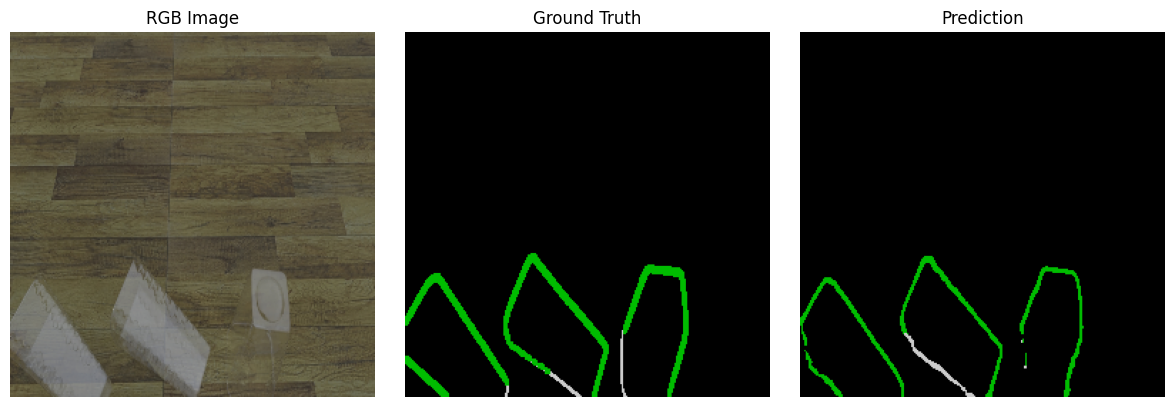

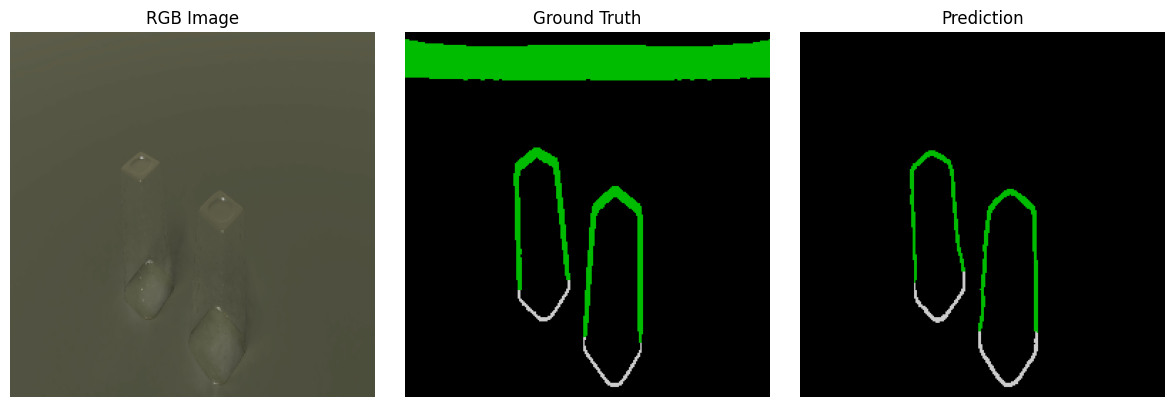

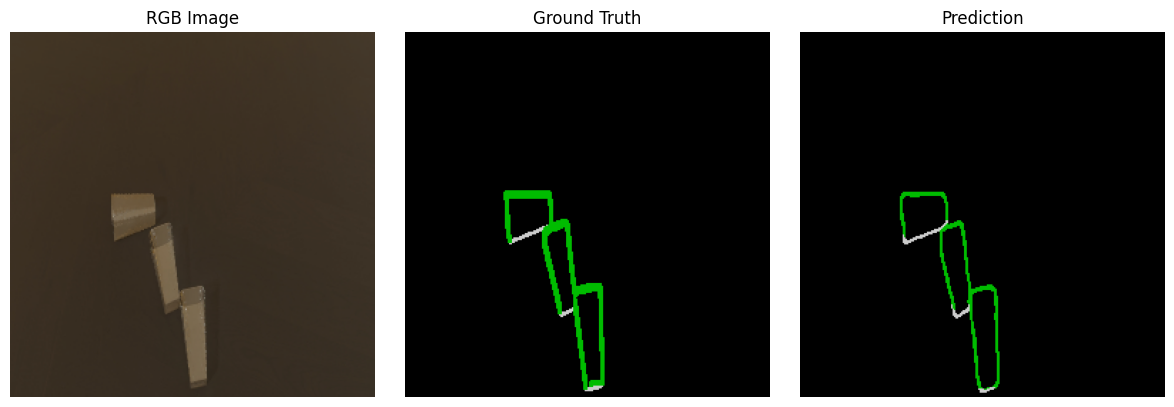

In [ ]:
#실행
if __name__ == '__main__':
    train_model(n_epochs=50)
    visualize_predictions()

In [ ]:
'''
#최초 1회만 실행 - 이미 드라이브에 파일 만들어져 있음!
#외곽선 이미지와 RGB 이미지 매칭시키기
import os
import shutil

# 원본 폴더
test_img_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/images"
test_edge_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/outlines/outline"

# 저장할 폴더
matched_img_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/image"
matched_edge_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/outline"
os.makedirs(matched_img_dir, exist_ok=True)
os.makedirs(matched_edge_dir, exist_ok=True)

# 파일명에서 번호만 추출하는 함수
import re
def extract_id(filename):
    match = re.search(r'\((\d+)\)', filename)
    return match.group(1) if match else None

# RGB 이미지와 엣지 이름 목록 불러오기
img_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))]
edge_files = [f for f in os.listdir(test_edge_dir) if f.endswith(('.jpg', '.png'))]

# ID 매핑
img_dict = {extract_id(f): f for f in img_files}
edge_dict = {extract_id(f): f for f in edge_files}

# 공통 ID 추출
common_ids = set(img_dict.keys()).intersection(set(edge_dict.keys()))

print(f"매칭된 샘플 수: {len(common_ids)}")

# 매칭된 파일 복사
for id_ in common_ids:
    src_img = os.path.join(test_img_dir, img_dict[id_])
    src_edge = os.path.join(test_edge_dir, edge_dict[id_])

    dst_img = os.path.join(matched_img_dir, img_dict[id_])
    dst_edge = os.path.join(matched_edge_dir, edge_dict[id_])

    shutil.copy(src_img, dst_img)
    shutil.copy(src_edge, dst_edge)
    '''

✅ 매칭된 샘플 수: 109


In [ ]:
#테스트셋 정의
test_dataset = ClearGraspDataset(
    image_dir="/content/drive/MyDrive/Cleargrasp_Dataset/test/image",
    edge_dir="/content/drive/MyDrive/Cleargrasp_Dataset/test/outline",
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
#학습된 best 모델 로드
model.load_state_dict(torch.load("best_cleargrasp_unet.pth"))
model.eval()

#필요 라이브러리 출력
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#혼동행렬 함수 지정
def plot_confusion_matrix(cm, class_names=None, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()

#정확도 함수 지정
def calculate_classwise_accuracy(loader, num_classes=3, class_names=["BG", "Occlusion", "Contact"]):
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for imgs, edges in tqdm(loader, desc="Testing"):
            imgs, edges = imgs.cuda(), edges.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            y_true_all.extend(edges.view(-1).cpu().numpy())
            y_pred_all.extend(preds.view(-1).cpu().numpy())

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(num_classes)))

    #각 클래스별 정확도
    acc_per_class = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(acc_per_class):
        print(f"Class {i} ({class_names[i]}) Accuracy: {acc:.4f}")

    #전체 픽셀 정확도
    pixel_acc = np.mean(np.array(y_true_all) == np.array(y_pred_all))
    print(f"\n🎯 Total Pixel Accuracy: {pixel_acc * 100:.2f}%")

    #혼동행렬 시각화
    plot_confusion_matrix(cm, class_names=class_names, normalize=True)

In [ ]:
#f1스코어 같은 지표 표현
from sklearn.metrics import classification_report

def calculate_metrics(loader, num_classes=3, class_names=["BG", "Occlusion", "Contact"]):
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for imgs, edges in tqdm(loader, desc="Testing"):
            imgs, edges = imgs.cuda(), edges.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            y_true_all.extend(edges.view(-1).cpu().numpy())
            y_pred_all.extend(preds.view(-1).cpu().numpy())

    # 혼동행렬
    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(num_classes)))
    plot_confusion_matrix(cm, class_names=class_names, normalize=True)

    # 정밀도, 재현율, F1 출력
    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all, target_names=class_names, digits=4))

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
from tqdm import tqdm

#IoU, Dice score 출력
def calculate_iou_and_dice(loader, num_classes=3, class_names=["BG", "Occlusion", "Contact"]):
    y_true_all, y_pred_all = [], []

    model.eval()
    with torch.no_grad():
        for imgs, edges in tqdm(loader, desc="Evaluating"):
            imgs, edges = imgs.cuda(), edges.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            y_true_all.append(edges.view(-1).cpu().numpy())
            y_pred_all.append(preds.view(-1).cpu().numpy())

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    ious = []
    dices = []

    print("\nPer-class Evaluation:\n")
    for cls in range(num_classes):
        tp = np.logical_and(y_pred_all == cls, y_true_all == cls).sum()
        fp = np.logical_and(y_pred_all == cls, y_true_all != cls).sum()
        fn = np.logical_and(y_pred_all != cls, y_true_all == cls).sum()

        denom_iou = tp + fp + fn
        denom_dice = 2 * tp + fp + fn

        iou = tp / denom_iou if denom_iou != 0 else float('nan')
        dice = (2 * tp) / denom_dice if denom_dice != 0 else float('nan')

        ious.append(iou)
        dices.append(dice)

        print(f"[Class {cls} - {class_names[cls]}]")
        print(f"   IoU   : {iou:.4f}")
        print(f"   Dice  : {dice:.4f}\n")

    # 평균 계산 (NaN 제외)
    mean_iou = np.nanmean(ious)
    mean_dice = np.nanmean(dices)

    print(f"Mean IoU (mIoU)      : {mean_iou:.4f}")
    print(f"Mean Dice Score (mDice) : {mean_dice:.4f}")

**예측값과 정답이 얼마나 잘 겹쳤는지를 나타내는 수치**

IoU :  예측결과와 정답의 교집합을 합집합으로 나눈 값

Dice score : 예측결과와 정답의 2배 교집합을 합으로 나눈 값

In [ ]:
calculate_iou_and_dice(test_loader) #평가지표 중 Iou, Dice score 출력

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Per-class Evaluation:

[Class 0 - BG]
   IoU   : 0.9674
   Dice  : 0.9834

[Class 1 - Occlusion]
   IoU   : 0.5305
   Dice  : 0.6933

[Class 2 - Contact]
   IoU   : 0.2358
   Dice  : 0.3816

Mean IoU (mIoU)      : 0.5779
Mean Dice Score (mDice) : 0.6861


정밀도(precision) : 양성이라고 예측한 값 중 실제로 양성인 것의 비율

민감도(recall) : 실제 양성 중 정답 비율(정확도와 같은 역할)

F1스코어 : 2x정밀도x민감도 / 정밀도+민감도

Macro avg. : 모든 클래스의 평균

Weighted avg. : 각 클래스의 샘플수를 반영한 평균(=비율 불균형 고려한 값)

Testing: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


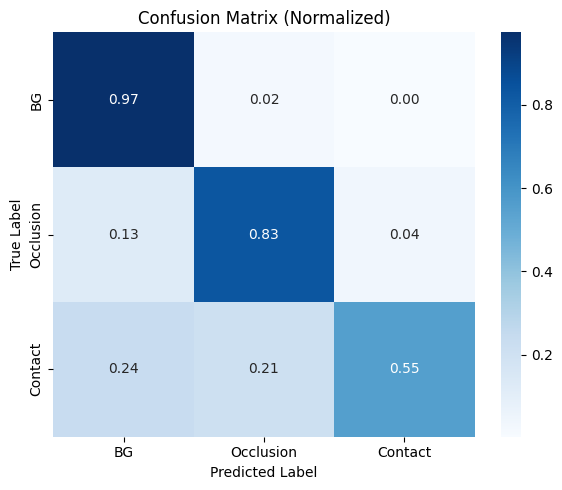


Classification Report:
              precision    recall  f1-score   support

          BG     0.9936    0.9734    0.9834    125363
   Occlusion     0.5939    0.8326    0.6933      5215
     Contact     0.2909    0.5547    0.3816       494

    accuracy                         0.9663    131072
   macro avg     0.6261    0.7869    0.6861    131072
weighted avg     0.9751    0.9663    0.9696    131072



In [ ]:
calculate_metrics(test_loader) #평가지표 출력